# 03 - Entrenamiento y Evaluación de Modelos

**Objetivo:** En este notebook, se entrenarán diferentes modelos de clasificación utilizando los datos preprocesados. Se evaluará su rendimiento con métricas apropiadas para datasets desbalanceados y se compararán para seleccionar el mejor.

## 1. Carga de Datos y Librerías
Cargamos los conjuntos de datos de entrenamiento y prueba que fueron preparados y guardados en el notebook anterior.

In [8]:
import pandas as pd
from joblib import load
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE

# Carga los datos preprocesados desde el archivo joblib
datos = load('../data/processed/cicids2017_preprocessed_data.joblib')

X_train_scaled = datos['X_train_scaled']
X_test_scaled = datos['X_test_scaled']
y_train = datos['y_train']
y_test = datos['y_test']

print("Datos cargados. Formas:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

Datos cargados. Formas:
X_train_scaled: (1979513, 39)
X_test_scaled: (848363, 39)


## 2. Modelo Base: Regresión Logística

Comenzamos con un modelo simple y rápido como la Regresión Logística para establecer un rendimiento de referencia (baseline). Cualquier modelo más complejo que probemos después deberá superar a este.

In [9]:
# Inicializamos el modelo de Regresión Logística
# n_jobs = -1 usa todos los núcleos de tu CPU para acelerar el entrenamiento
lr_model = LogisticRegression(random_state = 42, n_jobs = -1, max_iter = 1000)

# Entrenamos el modelo SÓLO con los datos de entrenamiento
print("Entrenando el modelo de Regresión Logística...")
lr_model.fit(X_train_scaled, y_train)

Entrenando el modelo de Regresión Logística...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 2.1. Evaluación del Modelo Base

Generamos el reporte de clasificación para analizar el rendimiento del modelo en el conjunto de prueba. Nos enfocamos en **Precision**, **Recall** y **F1-Score** debido al desbalance de clases.

In [10]:
# Hacemos predicciones sobre el conjunto de prueba
y_pred = lr_model.predict(X_test_scaled)

# Generamos y mostramos el reporte de clasificación
print("\nReporte de Clasificación - Regresión Logística:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación - Regresión Logística:


c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                          precision    recall  f1-score   support

                  BENIGN       0.98      0.98      0.98    681396
                     Bot       0.93      0.02      0.05       587
                    DDoS       0.91      0.99      0.95     38408
           DoS GoldenEye       0.93      0.74      0.82      3088
                DoS Hulk       0.98      0.87      0.92     69037
        DoS Slowhttptest       0.87      0.77      0.81      1650
           DoS slowloris       0.89      0.47      0.61      1739
             FTP-Patator       0.96      0.33      0.49      2380
              Heartbleed       0.43      1.00      0.60         3
            Infiltration       0.14      0.09      0.11        11
                PortScan       0.81      1.00      0.89     47641
             SSH-Patator       0.94      0.51      0.66      1769
  Web Attack Brute Force       0.00      0.00      0.00       452
Web Attack Sql Injection       0.00      0.00      0.00         6
         

c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Análisis de Resultados (Regresión Logística)

El reporte de clasificación de nuestro modelo base de Regresión Logística nos da varias pistas importantes sobre su rendimiento en los datos desbalanceados.

**Fortalezas** 
- El modelo es extremadamente bueno para identificar el tráfico BENIGN, con un f1-score de 0.98.

- También muestra un rendimiento muy alto para las clases de ataques más comunes en el dataset, como DDoS (0.95), DoS Hulk (0.92) y PortScan (0.89). Particularmente, el recall para PortScan y DDoS es casi perfecto (1.00 y 0.99), lo que significa que el modelo es muy eficaz para no dejar pasar estos tipos de ataques.

**Debilidades**
- El modelo es completamente incapaz de identificar cualquiera de los ataques de tipo Web Attack (Brute Force, Sql Injection, XSS). Obtuvo un 0.00 en todas las métricas para estas clases, lo que significa que nunca predijo una de ellas. Esto es la causa de la advertencia UndefinedMetricWarning.

- El rendimiento es muy pobre para otras clases minoritarias. Por ejemplo, Bot tiene un recall de solo 0.02 (detecta solo el 2% de los ataques de Bot) y FTP-Patator un recall de 0.33 (deja pasar 2 de cada 3 ataques).

**Conclusión General**

El modelo base está fuertemente sesgado hacia las clases con más datos. Es muy competente para la tarea de "Benigno vs. Ataque Común", pero ignora casi por completo los ataques más raros y con menos ejemplos (support).

El objetivo principal para los siguientes modelos será mejorar drásticamente el recall de estas clases minoritarias, ya sea con un algoritmo más complejo o con técnicas de balanceo de datos.

## 3. Modelo Avanzado: Random Forest Classifier

Ahora, entrenaremos un modelo más complejo y potente para ver si podemos mejorar el rendimiento, especialmente el **recall** de las clases minoritarias que el modelo base no pudo detectar.

In [11]:
# Inicializamos el modelo Random Forest
# n_estimators = 100 significa que construirá 100 árboles de decisión.
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)

# Entrenamos el modelo
print("Entrenando el modelo de Random Forest (esto tardará varios minutos)...")
rf_model.fit(X_train_scaled, y_train)

Entrenando el modelo de Random Forest (esto tardará varios minutos)...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 3.1. Evaluación del Random Forest
Veamos si este modelo más complejo superó a nuestro baseline.

In [12]:
# Hacemos predicciones con el nuevo modelo
y_pred_rf = rf_model.predict(X_test_scaled)

# Generamos y mostramos su reporte de clasificación
print("\nReporte de Clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf))


Reporte de Clasificación - Random Forest:
                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00    681396
                     Bot       0.84      0.78      0.81       587
                    DDoS       1.00      1.00      1.00     38408
           DoS GoldenEye       1.00      0.99      0.99      3088
                DoS Hulk       1.00      1.00      1.00     69037
        DoS Slowhttptest       0.99      0.99      0.99      1650
           DoS slowloris       1.00      1.00      1.00      1739
             FTP-Patator       1.00      1.00      1.00      2380
              Heartbleed       1.00      1.00      1.00         3
            Infiltration       1.00      0.64      0.78        11
                PortScan       0.99      0.99      0.99     47641
             SSH-Patator       1.00      1.00      1.00      1769
  Web Attack Brute Force       0.74      0.74      0.74       452
Web Attack Sql Injection       0

### Análisis de Resultados (Random Forest)

El **RandomForestClassifier** demuestra ser un modelo **significativamente superior** al baseline de Regresión Logística, con mejoras drásticas en casi todas las clases.

#### Puntos Clave:
* **Mejora Drástica en Clases Minoritarias:** El hallazgo más importante es la capacidad del modelo para detectar clases que antes eran invisibles. Los ataques de tipo **Web Attack**, que tenían un **f1-score** de 0.00, ahora son detectados (ej. **Brute Force** con 0.74). El **f1-score** de **Bot** saltó de 0.05 a un excelente 0.81.
* **Rendimiento Casi Perfecto:** Muchas otras clases de ataques (**DoS slowloris**, **FTP-Patator**, etc.) ahora alcanzan un **f1-score** de prácticamente 1.00, mostrando una capacidad de clasificación casi perfecta.
* **Advertencia de Sobreajuste (Overfitting):** Una **accuracy** general de **1.00** y tantos scores perfectos son una "bandera roja". Podría indicar que el modelo está **memorizando** los datos de entrenamiento muy bien, y aunque el rendimiento en el conjunto de prueba es espectacular, podría no generalizar tan bien a datos del mundo real completamente nuevos.
* **Debilidades Persistentes:** A pesar de la gran mejora, el modelo todavía sufre con las clases que tienen un número de ejemplos extremadamente bajo (**support**), como **Web Attack Sql Injection**.

**Conclusión:** RandomForest es el claro ganador hasta ahora. El siguiente paso será aplicar técnicas de balanceo de datos (SMOTE) para intentar mejorar el rendimiento en las pocas clases que aún son débiles.

#### Matriz de Confusión (Random Forest)
Para entender mejor los errores del modelo Random Forest, visualizamos su matriz de confusión. Pondremos especial atención a las filas de las clases con **recall** más bajo para ver con qué están siendo confundidas.

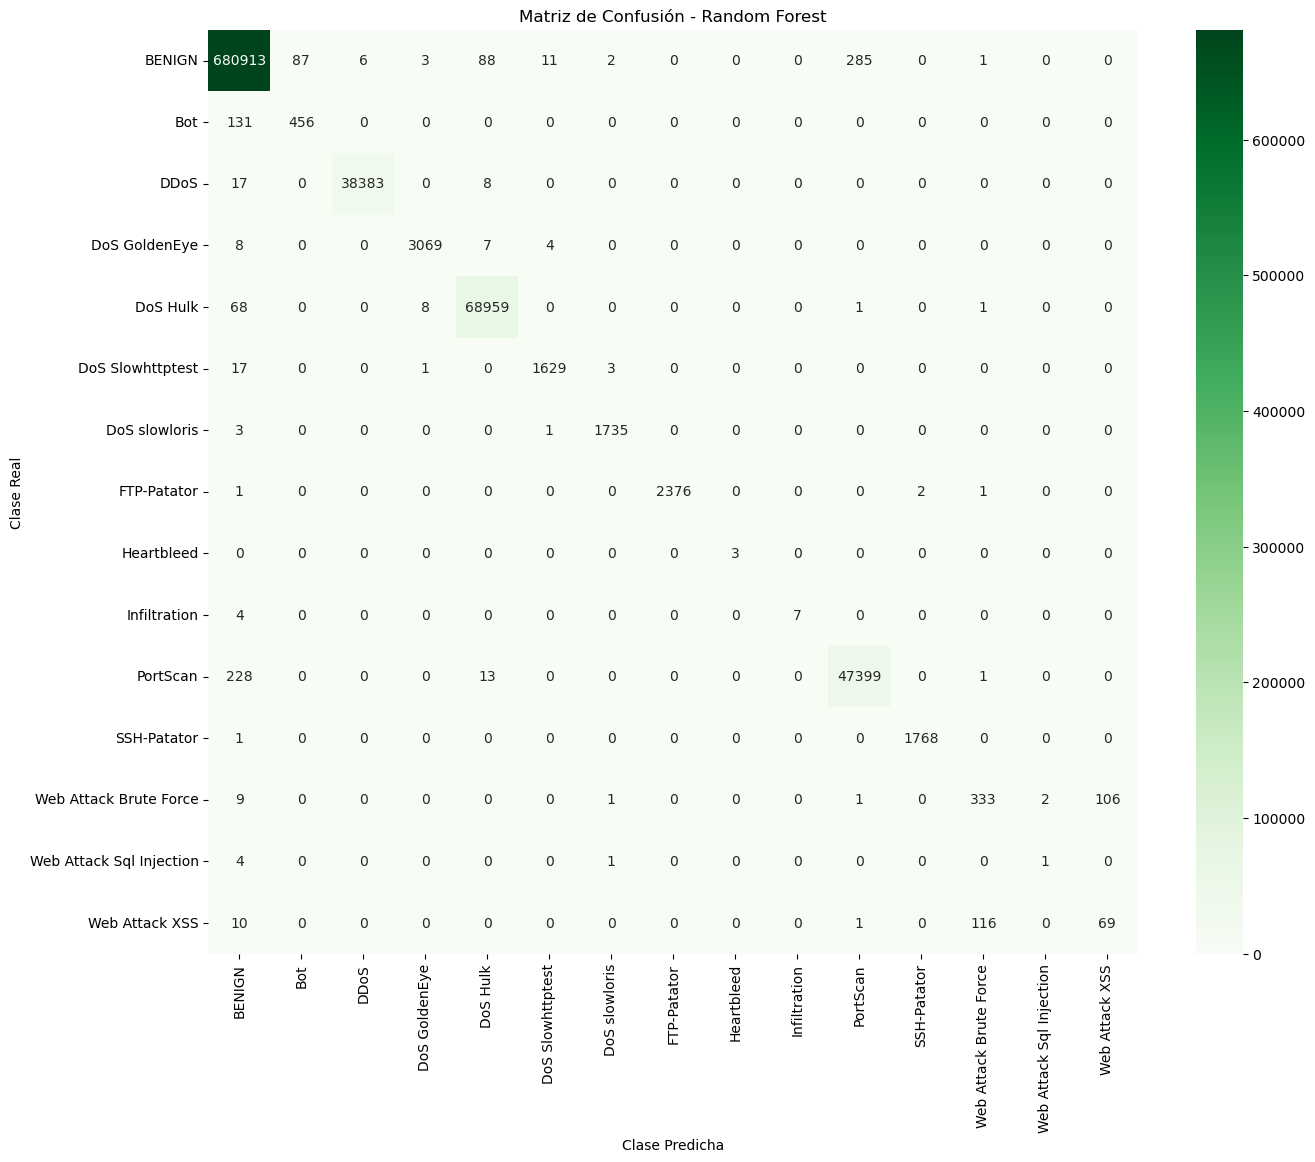

In [13]:
# Usamos 'y_test' (valores reales) y 'y_pred_rf' (predicciones del Random Forest)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Para que sea más legible, la podemos convertir a un DataFrame y visualizarla con un mapa de calor (heatmap).
cm_df = pd.DataFrame(
    cm_rf,
    index=rf_model.classes_,
    columns=rf_model.classes_
)

# Visualización de la matriz de confusión con seaborn
plt.figure(figsize = (15, 12))
sns.heatmap(cm_df, annot = True, fmt = 'd', cmap = 'Greens') # 'annot=True' para mostrar los números en cada celda, 'fmt=d' para formato entero
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()

## Análisis de la Matriz de Confusión (Random Forest)

La matriz de confusión confirma el alto rendimiento general del **RandomForest**, evidenciado por los números muy altos en la diagonal principal (los aciertos). Sin embargo, nos permite analizar en detalle los errores que aún comete, especialmente en las clases minoritarias.

**Hallazgos Clave**
- **Confusión con BENIGN:** Para varias de las clases con recall más bajo, el error principal es una confusión con la clase **BENIGN**.

- **Bot:** De los 587 ataques de tipo Bot, el modelo predijo correctamente 456, pero se confundió y predijo que 131 de ellos eran **BENIGN**.

- **Infiltration:** De 11 ataques, 4 fueron incorrectamente clasificados como **BENIGN**.

- Esto confirma que cuando el modelo tiene dudas sobre una clase rara, su sesgo lo inclina a predecir la clase mayoritaria.

**Confusión DENTRO de los Web Attacks: Este es el hallazgo más interesante.**

- Para **Web Attack XSS (Clase Real)**, el modelo solo acertó 69 veces. Su error más grande fue predecir que 116 de estos ataques eran **Web Attack Brute Force**.

- De manera similar, para **Web Attack Brute Force**, el modelo se confundió y predijo que 106 de ellos eran **Web Attack XSS**.

- El modelo es bueno identificando que "algo es un **Web Attack**", pero le cuesta mucho trabajo distinguir entre los subtipos de ataques web.

**Éxito en la Separación General:** Es notable que el modelo casi nunca confunde las grandes categorías de ataques entre sí. Por ejemplo, casi ningún ataque **DDoS** se confunde con **PortScan**, y viceversa.

**Conclusión:** El RandomForest es excelente para identificar los patrones de las principales categorías de ataque, pero sus debilidades son: 
1. Un sesgo residual a predecir **BENIGN** cuando duda de un ataque raro.
2. Dificultad para diferenciar entre tipos de ataques muy similares (como **XSS** vs **Brute Force**).

## 4. Experimento con Datos Balanceados (SMOTE)

Hemos identificado que el principal problema del modelo es su rendimiento en las clases minoritarias debido al desbalance de clases. Ahora aplicaremos la técnica SMOTE al conjunto de entrenamiento para crear un dataset balanceado y veremos si esto mejora el rendimiento del **RandomForestClassifier**.

In [14]:
# Inicializamos SMOTE
smote = SMOTE(random_state = 42)

# Aplicamos SMOTE SÓLO al conjunto de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Verificamos el resultado
print("Dimensiones de X_train antes de SMOTE:", X_train_scaled.shape)
print("Dimensiones de X_train después de SMOTE:", X_train_smote.shape)
print("\nDistribución de clases en y_train ANTES de SMOTE:")
print(y_train.value_counts())
print("\nDistribución de clases en y_train DESPUÉS de SMOTE:")
print(pd.Series(y_train_smote).value_counts())

c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Exception in thread Thread-65 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\brand\anaconda3\envs\cyber-project-py311\Lib\threading.py", line 98

Dimensiones de X_train antes de SMOTE: (1979513, 39)
Dimensiones de X_train después de SMOTE: (23848860, 39)

Distribución de clases en y_train ANTES de SMOTE:
Label
BENIGN                      1589924
DoS Hulk                     161087
PortScan                     111163
DDoS                          89617
DoS GoldenEye                  7205
FTP-Patator                    5555
SSH-Patator                    4128
DoS slowloris                  4057
DoS Slowhttptest               3849
Bot                            1369
Web Attack Brute Force         1055
Web Attack XSS                  456
Infiltration                     25
Web Attack Sql Injection         15
Heartbleed                        8
Name: count, dtype: int64

Distribución de clases en y_train DESPUÉS de SMOTE:
Label
BENIGN                      1589924
Bot                         1589924
DDoS                        1589924
DoS GoldenEye               1589924
DoS Hulk                    1589924
DoS Slowhttptest            1

### 4.1. Entrenar Random Forest con Datos Balanceados
Ahora entrenamos un nuevo modelo Random Forest desde cero, pero esta vez con los datos de entrenamiento balanceados.

In [15]:
# Creamos un nuevo modelo para este experimento
rf_model_smote = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)

# Entrenamos con los datos generados por SMOTE
rf_model_smote.fit(X_train_smote, y_train_smote)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 4.2. Evaluación del Modelo con SMOTE
Finalmente, evaluamos este nuevo modelo en el conjunto de prueba **original y sin balancear** (**X_test_scaled**, **y_test**).

In [16]:
# Hacemos predicciones sobre el conjunto de prueba original
y_pred_rf_smote = rf_model_smote.predict(X_test_scaled)

# Generamos y mostramos el reporte de clasificación
print("\nReporte de Clasificación - Random Forest con SMOTE:")
print(classification_report(y_test, y_pred_rf_smote))


Reporte de Clasificación - Random Forest con SMOTE:
                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00    681396
                     Bot       0.69      0.95      0.80       587
                    DDoS       1.00      1.00      1.00     38408
           DoS GoldenEye       0.99      1.00      0.99      3088
                DoS Hulk       1.00      1.00      1.00     69037
        DoS Slowhttptest       0.97      0.99      0.98      1650
           DoS slowloris       1.00      0.98      0.99      1739
             FTP-Patator       1.00      1.00      1.00      2380
              Heartbleed       1.00      1.00      1.00         3
            Infiltration       1.00      0.73      0.84        11
                PortScan       0.99      1.00      1.00     47641
             SSH-Patator       1.00      1.00      1.00      1769
  Web Attack Brute Force       0.73      0.61      0.67       452
Web Attack Sql Injecti

### Análisis de Resultados (Random Forest con SMOTE)

La aplicación de SMOTE al conjunto de entrenamiento tuvo un **éxito notable** en el objetivo principal: mejorar la capacidad del modelo para detectar las clases ultra minoritarias.

#### Puntos Clave:

* **Victorias Clave (Mejora del **Recall**):**
    El **recall** (la capacidad de encontrar todos los casos positivos) mejoró drásticamente para las clases más débiles:
    * **Web Attack Sql Injection**: El **recall** saltó de 0.17 a **0.50**. ¡Ahora detecta la mitad de estos ataques, en lugar de casi ninguno!
    * **Bot**: El **recall** subió de 0.78 a un increíble **0.95**.
    * **Infiltration**: El **recall** mejoró de 0.64 a **0.73**.
    * **Web Attack XSS**: El **recall** subió de 0.35 a **0.47**.

* **El Trade-off de Precision-Recall:**
    Al forzar al modelo a ser más sensible a las clases raras (aumentando el **recall**), es normal que su precisión (**precision**) baje un poco en esas mismas clases. El modelo se vuelve "más paranoico" y a veces genera más falsos positivos. Esto se ve en **Web Attack Brute Force**, cuyo **f1-score** bajó ligeramente, y en **Bot**, cuya precisión disminuyó.

### Conclusión Final del Proyecto

Después de todo el proceso de ingesta, limpieza, exploración, preprocesamiento y modelado, hemos llegado a una conclusión clara.

El modelo **Random Forest entrenado con datos balanceados por SMOTE es el claro ganador**. Para un sistema de detección de intrusiones, es mucho más crítico **no dejar pasar un ataque** (tener un **recall** alto) que tener algunas falsas alarmas (una **precision** ligeramente más baja).

Este modelo final, aunque no es perfecto, demuestra una capacidad robusta para identificar no solo el tráfico común, sino también una porción significativa de los ataques más raros y peligrosos, cumpliendo el objetivo principal del proyecto.